In [94]:
from sklearn.metrics import f1_score, precision_score, confusion_matrix, recall_score, accuracy_score
import datetime as dt
import pandas_datareader as pdr
from pandas.plotting import register_matplotlib_converters
import matplotlib.pyplot as plt
from ta import add_all_ta_features
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
register_matplotlib_converters()
import numpy as np
from ta.momentum import RSIIndicator
from ta.trend import MACD
from ta.volatility import bollinger_pband
import seaborn as sns
import time

import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import scipy.stats as stats
import sklearn.preprocessing as prep
pd.set_option('display.max_rows', None)
pd.set_option('display.expand_frame_repr', False)
from datetime import datetime
import yfinance as yf
import pandas_datareader.data as pdr
import pandas as pd
yf.pdr_override()

In [26]:
#pip install yfinance==0.1.62

In [95]:
## get data
start = datetime.strptime('1990-01-01', '%Y-%m-%d')
end = datetime.strptime('2021-08-01', '%Y-%m-%d')
data = pdr.get_data_yahoo("AAPL", start, end)


[*********************100%***********************]  1 of 1 completed


In [96]:
# exponential smoothing
def get_exp_preprocessing(df):
    edata = df.ewm(alpha=0.9).mean()    
    return edata

data = get_exp_preprocessing(data)

In [12]:
start_sp = datetime.strptime('2010-01-01', '%Y-%m-%d')
end_sp = datetime.strptime('2021-01-01', '%Y-%m-%d')

yf.pdr_override() 
sp500=pdr.get_data_yahoo('^GSPC', 
                        start_sp,
                        end_sp)


[*********************100%***********************]  1 of 1 completed


In [15]:
sp500['Log_Ret_1d']=np.log(sp500['Close'] / sp500['Close'].shift(1))

sp500['Log_Ret_1w']=pd.Series(sp500['Log_Ret_1d']).rolling(window=5).sum()
sp500['Log_Ret_80w']=pd.Series(sp500['Log_Ret_1d']).rolling(window=400).sum()

sp500['Vol_1w']=pd.Series(sp500['Log_Ret_1d']).rolling(window=5).std()*np.sqrt(5)
sp500['Vol_80w']=pd.Series(sp500['Log_Ret_1d']).rolling(window=400).std()*np.sqrt(400)

sp500['Volume_1w']=pd.Series(sp500['Volume']).rolling(window=5).mean()
sp500['Volume_80w']=pd.Series(sp500['Volume']).rolling(window=400).mean()

sp500['Return_Label']=pd.Series(sp500['Log_Ret_1d']).shift(-21).rolling(window=21).sum()
sp500['Label']=np.where(sp500['Return_Label'] > 0, 1, 0)

sp500=sp500.dropna("index")
sp500=sp500.drop(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', "Return_Label"], axis=1)

In [97]:
data['Open'] = data['Open'].pct_change() # Create arithmetic returns column
data['High'] = data['High'].pct_change() # Create arithmetic returns column
data['Low'] = data['Low'].pct_change() # Create arithmetic returns column
data['Close'] = data['Close'].pct_change() # Create arithmetic returns column
data['Volume'] = data['Volume'].pct_change()


In [98]:
# add prediction column (up or down next day / buy or sell)

data['pred'] = data['Adj Close']
predList = []

for i in data['pred']:
    predList.append(i)

y = 0

while y < data.shape[0] -1 :
    diff = predList[y] - predList[y+1]
    if diff > 0:
        predList[y] = 0
    else:
        predList[y] = 1
    y += 1

data['pred'] = predList


In [99]:
display(data)

Open          High       Low     Close   Adj Close     Volume        pred
Date                                                                                     
1990-01-02       NaN           NaN       NaN       NaN    0.267212        NaN    1.000000
1990-01-03  0.070923  1.212320e-02  0.064934  0.006101    0.268842   0.123050    1.000000
1990-01-04  0.011932  1.888014e-02 -0.000549  0.003554    0.269797   0.069065    1.000000
1990-01-05 -0.010613 -9.802240e-03 -0.006095  0.003342    0.270699  -0.395468    1.000000
1990-01-08 -0.007027 -6.864557e-03 -0.000613  0.006295    0.272403  -0.212498    0.000000
1990-01-09  0.011285 -6.911320e-04 -0.000061 -0.008262    0.270153  -0.159633    0.000000
1990-01-10 -0.007776 -8.949463e-03 -0.030412 -0.039668    0.259436   1.142657    0.000000
1990-01-11 -0.033646 -3.376093e-02 -0.034493 -0.041459    0.248680   0.107432    0.000000
1990-01-12 -0.052944 -4.059117e-02 -0.023062 -0.004325    0.247605  -0.159070    0.000000
1990-01-15  0.000938  2.154493e-02  0.010940 -0.006953    0.245883  -0.070984    1.000000
1990-01-16 -0.025997 -1.681509e-02 -0.038382  0.015709    0.249746   0.282047    0.000000
1990-01-17  0.030814 -8.126169e-03  0.002848 -0.040461    0.239641  -0.050925    0.000000
1990-01-18 -0.042485 -3.316480e-02 -0.020179 -0.027788    0.232982   0.339213    1.000000
1990-01-19  0.015915  2.333437e-02  0.032745  0.049099    0.244421  -0.002278    0.000000
1990-01-22  0.008244  2.280230e-03 -0.003569 -0.021735    0.239108  -0.405853    1.000000
1990-01-23 -0.005806 -6.295417e-03 -0.007122  0.011278    0.241805  -0.095369    1.000000
1990-01-24 -0.033894 -6.335300e-04 -0.021157  0.007790    0.243689   0.172045    1.000000
1990-01-25  0.044764  1.307351e-02  0.046559  0.004087    0.244685  -0.299123    0.000000
1990-01-26 -0.002319 -1.816357e-02 -0.042104 -0.035874    0.235907   0.493115    1.000000
1990-01-29 -0.026694 -1.505722e-02 -0.007866  0.009962    0.238257  -0.282634    1.000000
1990-01-30  0.004054  2.529264e-02  0.023701  0.021308    0.243334  -0.064394    1.000000
1990-01-31  0.034254  9.006105e-03  0.002315  0.002086    0.243842   0.204005    0.000000
1990-02-01  0.003312 -2.347862e-03  0.013870 -0.009720    0.241471  -0.154216    1.000000
1990-02-02 -0.032291  3.012721e-03 -0.005358  0.015731    0.245270  -0.007689    1.000000
1990-02-05  0.023632  1.325341e-02  0.019749  0.021289    0.250492  -0.127693    0.000000
1990-02-06  0.015480 -5.083802e-03  0.001937 -0.004358    0.249400  -0.256810    0.000000
1990-02-07 -0.043876 -2.621194e-02 -0.039519 -0.039268    0.239606   2.758079    0.000000
1990-02-08  0.002194 -1.588664e-02 -0.011009 -0.010823    0.237013  -0.318555    1.000000
1990-02-09  0.006987  2.520452e-02  0.026761  0.032956    0.244824  -0.131591    0.000000
1990-02-12  0.020860  2.458487e-03  0.016178 -0.003405    0.243991  -0.505601    1.000000
1990-02-13 -0.004543  1.329143e-02  0.001592  0.012891    0.247136   0.187895    0.000000
1990-02-14  0.012774 -5.125778e-03  0.000159 -0.005258    0.245836  -0.038899    0.000000
1990-02-15 -0.018333 -1.345661e-02 -0.006651 -0.000529    0.245706   0.013711    0.000000
1990-02-16  0.011440  5.194898e-03  0.006042 -0.013193    0.243167   0.270408    0.000000
1990-02-20 -0.018603 -1.906130e-02 -0.019412 -0.007993    0.241294  -0.007429    1.000000
1990-02-21 -0.022001  1.136356e-02 -0.015585  0.012614    0.244345   0.383501    0.000000
1990-02-22  0.032013  7.700659e-03  0.012238 -0.025260    0.238173   0.129375    1.000000
1990-02-23 -0.030098 -2.534620e-02 -0.005618  0.004207    0.239175  -0.199737    1.000000
1990-02-26  0.003743  1.749231e-02  0.006301  0.020728    0.244133  -0.435455    0.000000
1990-02-27  0.027655  1.719159e-03  0.014271 -0.011234    0.241390  -0.135596    1.000000
1990-02-28 -0.010583 -6.401572e-03 -0.005319  0.012279    0.244354   0.407386    1.000000
1990-03-01 -0.001070  1.919625e-02 -0.000535  0.007842    0.246271   0.832377    0.000000
1990-03-02 -0.000107  1.883470e-03 -0.000054 -0.012374  

In [21]:
# add 10 indicators
data = add_all_ta_features(data, open="Open", high="High", low="Low", close="Close", volume="Volume", fillna=True)
data = data.dropna()
data_final = data[['volume_em', 'momentum_stoch_rsi', 'volatility_kcp', 'momentum_wr', 'momentum_stoch', 'volatility_bbp', 'volatility_dcp', 'volatility_kchi', 'momentum_rsi', 'Adj Close','pred']]
#data_final = data[['Adj Close','pred']]

In [100]:
data_final = data

In [19]:
display(y_close)

Date
2010-01-04      6.572422
2010-01-05      6.582751
2010-01-06      6.489336
2010-01-07      6.469305
2010-01-08      6.506001
2010-01-11      6.457985
2010-01-12      6.387125
2010-01-13      6.461021
2010-01-14      6.434691
2010-01-15      6.335320
2010-01-19      6.577181
2010-01-20      6.509880
2010-01-21      6.401987
2010-01-22      6.105956
2010-01-25      6.223397
2010-01-26      6.314468
2010-01-27      6.377196
2010-01-28      6.146043
2010-01-29      5.923091
2010-02-01      5.974595
2010-02-02      6.010979
2010-02-03      6.107763
2010-02-04      5.918987
2010-02-05      5.994363
2010-02-08      5.964859
2010-02-09      6.019126
2010-02-10      5.994977
2010-02-11      6.090684
2010-02-12      6.147520
2010-02-16      6.236675
2010-02-17      6.222096
2010-02-18      6.231140
2010-02-19      6.197219
2010-02-22      6.159277
2010-02-23      6.062614
2010-02-24      6.152453
2010-02-25      6.198472
2010-02-26      6.275490
2010-03-01      6.403978
2010-03-02      6.41

In [101]:
# Seperate X and Y data

def prepare_data(data):
    del (data['pred'])
    data = data.dropna()
    
    return data


Y = data_final['pred'].values
train_scaled = prepare_data(data_final)



In [40]:
Y.shape

(2755,)

In [139]:
display(X_train)

array([[[ 7.09233003e-02,  1.21232049e-02,  6.49337769e-02,
          6.10085592e-03,  2.68842101e-01,  1.23049904e-01]],

       [[ 1.19322198e-02,  1.88801432e-02, -5.49013009e-04,
          3.55367790e-03,  2.69797440e-01,  6.90654875e-02]],

       [[-1.06129081e-02, -9.80223990e-03, -6.09455465e-03,
          3.34192473e-03,  2.70699078e-01, -3.95467938e-01]],

       [[-7.02719477e-03, -6.86455658e-03, -6.12585534e-04,
          6.29484912e-03,  2.72403054e-01, -2.12497611e-01]],

       [[ 1.12849258e-02, -6.91132014e-04, -6.12900342e-05,
         -8.26167998e-03,  2.70152578e-01, -1.59633108e-01]],

       [[-7.77610774e-03, -8.94946296e-03, -3.04121223e-02,
         -3.96676117e-02,  2.59436366e-01,  1.14265686e+00]],

       [[-3.36459726e-02, -3.37609348e-02, -3.44934583e-02,
         -4.14588879e-02,  2.48680389e-01,  1.07432153e-01]],

       [[-5.29443399e-02, -4.05911745e-02, -2.30617709e-02,
         -4.32520664e-03,  2.47604791e-01, -1.59069669e-01]],

       [[ 9.3765

In [76]:
# Normalize between 0 and 1

min_max = MinMaxScaler((0, 1))
train_scaled = min_max.fit_transform(train_scaled)

In [23]:
"""
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
train_scaled = scaler.fit_transform(X)
"""

'\nfrom sklearn.preprocessing import StandardScaler\nscaler = StandardScaler()\ntrain_scaled = scaler.fit_transform(X)\n'

In [102]:
# Split train / test
factor = 0.80

length = train_scaled.shape[0]

total_for_train = int(length*factor)


X_train = np.array(train_scaled[:total_for_train])
Y_train = np.array(Y[:total_for_train])
X_test = np.array(train_scaled[total_for_train:])
Y_test = np.array(Y[total_for_train:])

"""
X_train = np.array(train_scaled[:total_for_train])
Y_train = np.array(y_close[:total_for_train])
X_test = np.array(train_scaled[total_for_train:])
Y_test = np.array(y_close[total_for_train:])
"""

'\nX_train = np.array(train_scaled[:total_for_train])\nY_train = np.array(y_close[:total_for_train])\nX_test = np.array(train_scaled[total_for_train:])\nY_test = np.array(y_close[total_for_train:])\n'

In [142]:
X_train[:,0]

array([[ 7.09233003e-02,  1.21232049e-02,  6.49337769e-02,
         6.10085592e-03,  2.68842101e-01,  1.23049904e-01],
       [ 1.19322198e-02,  1.88801432e-02, -5.49013009e-04,
         3.55367790e-03,  2.69797440e-01,  6.90654875e-02],
       [-1.06129081e-02, -9.80223990e-03, -6.09455465e-03,
         3.34192473e-03,  2.70699078e-01, -3.95467938e-01],
       [-7.02719477e-03, -6.86455658e-03, -6.12585534e-04,
         6.29484912e-03,  2.72403054e-01, -2.12497611e-01],
       [ 1.12849258e-02, -6.91132014e-04, -6.12900342e-05,
        -8.26167998e-03,  2.70152578e-01, -1.59633108e-01],
       [-7.77610774e-03, -8.94946296e-03, -3.04121223e-02,
        -3.96676117e-02,  2.59436366e-01,  1.14265686e+00],
       [-3.36459726e-02, -3.37609348e-02, -3.44934583e-02,
        -4.14588879e-02,  2.48680389e-01,  1.07432153e-01],
       [-5.29443399e-02, -4.05911745e-02, -2.30617709e-02,
        -4.32520664e-03,  2.47604791e-01, -1.59069669e-01],
       [ 9.37652178e-04,  2.15449305e-02,  1.093

ValueError: x and y must have same first dimension, but have shapes (6364,) and (7956,)

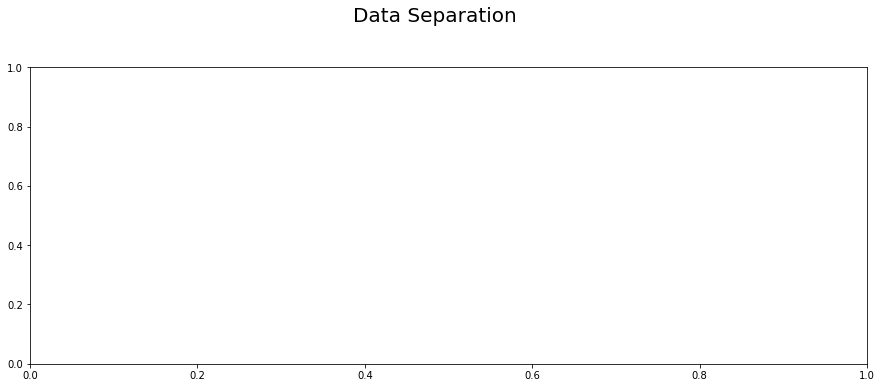

In [138]:

fig = plt.figure(figsize=(15,12))
st = fig.suptitle("Data Separation", fontsize=20)
st.set_y(0.95)

###############################################################################

ax1 = fig.add_subplot(211)
ax1.plot(np.arange(np.array(X_train.shape[0])), np.array(X_train[1]), label='Training data')

ax1.plot(np.arange(X_train.shape[0], 
                   X_train.shape[0]+X_test.shape[0]), train_scaled['Close'], label='Validation data')

ax1.plot(np.arange(X_train.shape[0]+X_test.shape[0], 
                   X_train.shape[0]+X_test.shape[0]), train_scaled['Close'], label='Test data')
ax1.set_xlabel('Date')
ax1.set_ylabel('Normalized Closing Returns')
ax1.set_title("Close Price", fontsize=18)
ax1.legend(loc="best", fontsize=12)

###############################################################################


In [103]:
# reshape input arrays
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1] ))
# X_train = np.expand_dims(X_train,0)
# X_test = np.expand_dims(X_test,0)
# Y_train = np.expand_dims(Y_train,0)
# Y_test = np.expand_dims(Y_test,0)

In [22]:
X_train = np.reshape(X_train, ( X_train.shape[1], X_train.shape[0],  X_train.shape[2]))
X_test = np.reshape(X_test, ( X_test.shape[1], X_test.shape[0],  X_test.shape[2]))

IndexError: tuple index out of range

In [112]:
print(X_train.shape)
print(Y_train.shape)

print(X_test.shape)
print(Y_test.shape)

(6364, 1, 6)
(6364,)
(1592, 1, 6)
(1593,)


In [113]:
Y_test = Y_test[:-1]

In [28]:
Y_train = tf.keras.utils.to_categorical(Y_train)

NameError: name 'tf' is not defined

In [72]:
from sklearn.model_selection import train_test_split

# Split the data
x_train, x_valid, y_train, y_valid = train_test_split(X, Y, test_size=0.33, shuffle= True)


In [45]:
Y_test = Y_test[:-1]
import sys
import numpy
numpy.set_printoptions(threshold=sys.maxsize)
display(X_train)

array([[[5.03201091e-03],
        [5.11155434e-03],
        [4.39217911e-03],
        [4.23792437e-03],
        [4.52051229e-03],
        [4.15074811e-03],
        [3.60506284e-03],
        [4.17412975e-03],
        [3.97136434e-03],
        [3.20612143e-03],
        [5.06865588e-03],
        [4.55038112e-03],
        [3.71951755e-03],
        [1.43982207e-03],
        [2.34421358e-03],
        [3.04554459e-03],
        [3.52859904e-03],
        [1.74852191e-03],
        [3.16035441e-05],
        [4.28223863e-04],
        [7.08412978e-04],
        [1.45373666e-03],
        [0.00000000e+00],
        [5.80457620e-04],
        [3.53255051e-04],
        [7.71150798e-04],
        [5.85183236e-04],
        [1.32221431e-03],
        [1.75989722e-03],
        [2.44646571e-03],
        [2.33419517e-03],
        [2.40384774e-03],
        [2.14262431e-03],
        [1.85043499e-03],
        [1.10604953e-03],
        [1.79788373e-03],
        [2.15227583e-03],
        [2.74537566e-03],
        [3.7

In [58]:
display(Y_train)

array([[[0., 1.],
        [1., 0.],
        [1., 0.],
        ...,
        [0., 1.],
        [1., 0.],
        [1., 0.]]], dtype=float32)

In [114]:
# Make model for up or down
from tensorflow.python.keras.layers import Input, Dense, LSTM, Dropout
from tensorflow.python.keras.models import Sequential
import tensorflow as tf
from keras.utils import plot_model
from keras.optimizers import SGD, Adam

def build_model():

    model=Sequential()
    model.add(tf.keras.layers.LSTM(100,input_shape=(X_train.shape[1], X_train.shape[2]),return_sequences=True))
    model.add(tf.keras.layers.LSTM(100,return_sequences=True))
    model.add(tf.keras.layers.LSTM(100,return_sequences=True))
    model.add(tf.keras.layers.LSTM(100,return_sequences=False))
    #model.add(tf.keras.layers.Dense(32,activation='relu'))
    model.add(tf.keras.layers.Dense(1,activation='sigmoid'))
    
    model.compile(loss='binary_crossentropy',optimizer="Adam",metrics=['acc'])

    
    history=model.fit(X_train,Y_train,batch_size=32,epochs=100, validation_data=(X_test,Y_test))
   
    return model

In [69]:
# # Make model for prices
# from tensorflow.python.keras.layers import Input, Dense, LSTM
# from tensorflow.python.keras.models import Sequential
# import tensorflow as tf

# def build_model():

#     model=Sequential()
#     model.add(tf.keras.layers.LSTM(100,input_shape=(X_train.shape[1], X_train.shape[2]),return_sequences=False))
#     #model.add(Dropout(0.2))
#     model.add(tf.keras.layers.Dense(32,activation='relu'))
#     model.add(tf.keras.layers.Dense(1,activation='sigmoid'))
    
#     model.compile(loss='mean_squared_error',optimizer="Adam")

    
#     history=model.fit(X_train,Y_train,batch_size=128,epochs=100,validation_data=(X_test,Y_test))
   
#     return model

In [115]:
model = build_model()


Train on 6364 samples, validate on 1592 samples
Epoch 1/100
6364/6364 [==============================] - 4s 572us/sample - loss: 0.6896 - acc: 0.5297 - val_loss: 0.7143 - val_acc: 0.5408
Epoch 2/100
6364/6364 [==============================] - 1s 194us/sample - loss: 0.4202 - acc: 0.7920 - val_loss: 0.9285 - val_acc: 0.5609
Epoch 3/100
6364/6364 [==============================] - 1s 192us/sample - loss: 0.2004 - acc: 0.9059 - val_loss: 1.2948 - val_acc: 0.5936
Epoch 4/100
6364/6364 [==============================] - 1s 192us/sample - loss: 0.1360 - acc: 0.9375 - val_loss: 1.9236 - val_acc: 0.6281
Epoch 5/100
6364/6364 [==============================] - 1s 193us/sample - loss: 0.1186 - acc: 0.9486 - val_loss: 1.4085 - val_acc: 0.5999
Epoch 6/100
6364/6364 [==============================] - 1s 193us/sample - loss: 0.0872 - acc: 0.9620 - val_loss: 1.3965 - val_acc: 0.6545
Epoch 7/100
6364/6364 [==============================] - 1s 195us/sample - loss: 0.0875 - acc: 0.9604 - val_loss: 1.33

6364/6364 [==============================] - 2s 242us/sample - loss: 0.0325 - acc: 0.9873 - val_loss: 0.4336 - val_acc: 0.8455
Epoch 60/100
6364/6364 [==============================] - 1s 221us/sample - loss: 0.0237 - acc: 0.9910 - val_loss: 0.6067 - val_acc: 0.8606
Epoch 61/100
6364/6364 [==============================] - 1s 208us/sample - loss: 0.0331 - acc: 0.9873 - val_loss: 0.2698 - val_acc: 0.9114
Epoch 62/100
6364/6364 [==============================] - 1s 205us/sample - loss: 0.0324 - acc: 0.9898 - val_loss: 0.1098 - val_acc: 0.9667
Epoch 63/100
6364/6364 [==============================] - 1s 210us/sample - loss: 0.0225 - acc: 0.9921 - val_loss: 0.1050 - val_acc: 0.9642
Epoch 64/100
6364/6364 [==============================] - 1s 213us/sample - loss: 0.0239 - acc: 0.9914 - val_loss: 0.1052 - val_acc: 0.9573
Epoch 65/100
6364/6364 [==============================] - 1s 209us/sample - loss: 0.0209 - acc: 0.9923 - val_loss: 1.1190 - val_acc: 0.7858
Epoch 66/100
6364/6364 [=========

In [15]:
def custom_loss(y_true,y_pred):
    return tf.square(y_true - y_pred[:,:,0])

In [63]:
from tensorflow.python.keras.layers import Input, Dense, LSTM
from tensorflow.python.keras.models import Sequential
import tensorflow as tf
def build_new_model():
    
    lstm = LSTM(100,input_shape=(X_train.shape[1], X_train.shape[2]),return_sequences=False)
    inputs = tf.keras.Input(shape=(X_train.shape[1], X_train.shape[2]))
    x= lstm(inputs)

    x=tf.keras.layers.Dense(units = 32, activation = 'relu', name = 'main_dense')(x)
    outputs = tf.keras.layers.Dense(units = 1, activation = 'sigmoid', name = 'main_dense2')(x)
    model = tf.keras.Model(inputs, outputs)
    model.compile(optimizer="Adam", loss='binary_crossentropy',  metrics = ['acc'])

    history = model.fit(X_train, Y_train, batch_size = 32, epochs = 100, validation_data=(X_test,Y_test), verbose=2)
    
    return model 

In [64]:

model = build_new_model()


[None, 100]
[None, 32]
[None, 1]
Train on 1937 samples, validate on 831 samples
Epoch 1/100
1937/1937 - 1s - loss: 0.6877 - acc: 0.5318 - val_loss: 0.6858 - val_acc: 0.5560
Epoch 2/100
1937/1937 - 0s - loss: 0.6864 - acc: 0.5348 - val_loss: 0.6868 - val_acc: 0.5560
Epoch 3/100
1937/1937 - 0s - loss: 0.6857 - acc: 0.5333 - val_loss: 0.6874 - val_acc: 0.5632
Epoch 4/100
1937/1937 - 0s - loss: 0.6851 - acc: 0.5431 - val_loss: 0.6881 - val_acc: 0.5391
Epoch 5/100
1937/1937 - 0s - loss: 0.6850 - acc: 0.5390 - val_loss: 0.6887 - val_acc: 0.5620
Epoch 6/100
1937/1937 - 0s - loss: 0.6858 - acc: 0.5287 - val_loss: 0.6886 - val_acc: 0.5463
Epoch 7/100
1937/1937 - 0s - loss: 0.6857 - acc: 0.5323 - val_loss: 0.6893 - val_acc: 0.5439
Epoch 8/100
1937/1937 - 0s - loss: 0.6851 - acc: 0.5385 - val_loss: 0.6892 - val_acc: 0.5367
Epoch 9/100
1937/1937 - 0s - loss: 0.6849 - acc: 0.5338 - val_loss: 0.6904 - val_acc: 0.5187
Epoch 10/100
1937/1937 - 0s - loss: 0.6855 - acc: 0.5385 - val_loss: 0.6915 - val_a

Epoch 87/100
1937/1937 - 0s - loss: 0.6839 - acc: 0.5560 - val_loss: 0.6902 - val_acc: 0.5259
Epoch 88/100
1937/1937 - 0s - loss: 0.6839 - acc: 0.5447 - val_loss: 0.6909 - val_acc: 0.5187
Epoch 89/100
1937/1937 - 0s - loss: 0.6840 - acc: 0.5488 - val_loss: 0.6901 - val_acc: 0.5235
Epoch 90/100
1937/1937 - 0s - loss: 0.6837 - acc: 0.5457 - val_loss: 0.6900 - val_acc: 0.5403
Epoch 91/100
1937/1937 - 0s - loss: 0.6834 - acc: 0.5555 - val_loss: 0.6894 - val_acc: 0.5367
Epoch 92/100
1937/1937 - 0s - loss: 0.6836 - acc: 0.5338 - val_loss: 0.6906 - val_acc: 0.5187
Epoch 93/100
1937/1937 - 0s - loss: 0.6837 - acc: 0.5457 - val_loss: 0.6908 - val_acc: 0.5150
Epoch 94/100
1937/1937 - 0s - loss: 0.6837 - acc: 0.5519 - val_loss: 0.6897 - val_acc: 0.5391
Epoch 95/100
1937/1937 - 0s - loss: 0.6841 - acc: 0.5478 - val_loss: 0.6903 - val_acc: 0.5343
Epoch 96/100
1937/1937 - 0s - loss: 0.6839 - acc: 0.5483 - val_loss: 0.6900 - val_acc: 0.5451
Epoch 97/100
1937/1937 - 0s - loss: 0.6836 - acc: 0.5390 - v

In [41]:
display(Y_test)

array([  0.        ,   1.        ,   1.        , ...,   1.        ,
         1.        , 145.83340626])

In [35]:
import sys
np.set_printoptions(threshold=sys.maxsize)

predictions = model.predict(X_test) 
display(predictions)

array([[0.49386328],
       [0.4991827 ],
       [0.5039447 ],
       [0.50587136],
       [0.50611544],
       [0.4871177 ],
       [0.48713887],
       [0.48001862],
       [0.47843748],
       [0.49415416],
       [0.50375074],
       [0.50260437],
       [0.51073664],
       [0.51046425],
       [0.51735306],
       [0.5138854 ],
       [0.59529895],
       [0.5925583 ],
       [0.5883269 ],
       [0.51589113],
       [0.58299047],
       [0.5079327 ],
       [0.5827723 ],
       [0.5968682 ],
       [0.59943914],
       [0.5879918 ],
       [0.49054575],
       [0.49076658],
       [0.4894514 ],
       [0.49213582],
       [0.49211258],
       [0.50107104],
       [0.59890604],
       [0.6165433 ],
       [0.61796683],
       [0.5984611 ],
       [0.59446496],
       [0.61125976],
       [0.60719556],
       [0.60140556],
       [0.5984066 ],
       [0.588308  ],
       [0.5771634 ],
       [0.49894708],
       [0.47844446],
       [0.4566003 ],
       [0.4721247 ],
       [0.473

In [21]:
from tensorflow.python import keras
print(keras.__version__)
import keras
print(keras.__version__)
import tensorflow
print(tensorflow.__version__)


2.2.4-tf
2.3.1
1.15.0


In [129]:
model.evaluate(X_test,Y_test)


1592/1592 [==============================] - 0s 59us/sample - loss: 0.4521 - acc: 0.8492


[0.4521242301517995, 0.8492462]

In [50]:
model.summary()


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 100)               44400     
_________________________________________________________________
dense_4 (Dense)              (None, 32)                3232      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 33        
Total params: 47,665
Trainable params: 47,665
Non-trainable params: 0
_________________________________________________________________


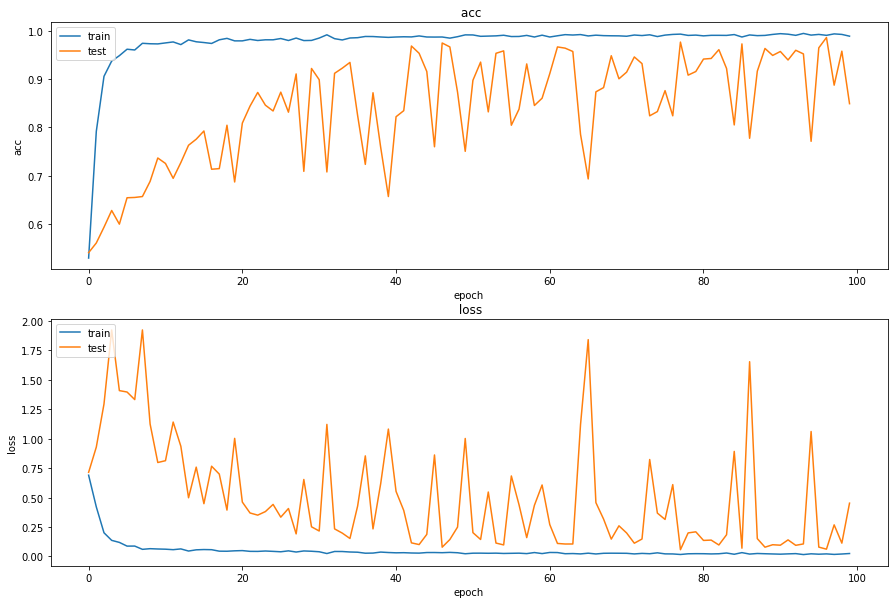

In [116]:

import matplotlib.pyplot as plt  
plt.figure(1, figsize=(15,10) )  


plt.subplot(211)  
plt.plot(model.history.history['acc'])  
plt.plot(model.history.history['val_acc'])  
plt.title(' acc')  
plt.ylabel('acc')  
plt.xlabel('epoch')  
plt.legend(['train', 'test'], loc='upper left')  

plt.subplot(212)  
plt.plot(model.history.history['loss'])  
plt.plot(model.history.history['val_loss'])  
plt.title(' loss')  
plt.ylabel('loss')  
plt.xlabel('epoch')  
plt.legend(['train', 'test'], loc='upper left')  
plt.show()  

453/453 [==============================] - 0s 77us/step


[0.6851022893493013, 0.5695364475250244]

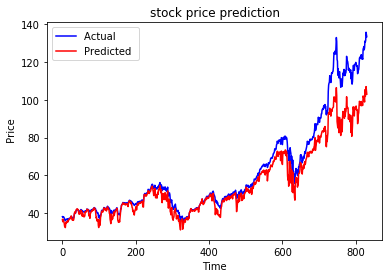

In [92]:
plt.plot(Y_test, color = 'blue', label = 'Actual ')
plt.plot(predictions, color = 'red', label = 'Predicted ')
plt.title('stock price prediction')
plt.xlabel('Time')
plt.ylabel(' Price')
plt.legend()
plt.show()

In [38]:

weights = model.layers[0].get_weights()


In [39]:
print(weights)

[array([[-0.06716995, -0.02403705, -0.06942601, ...,  0.10768736,
         0.07312027, -0.23714094],
       [ 0.10100991, -0.21928166,  0.00575211, ...,  0.04378307,
        -0.06718741,  0.03942737],
       [-0.0022946 , -0.04532431, -0.09758807, ...,  0.14459391,
         0.01391237, -0.20269997],
       ...,
       [ 0.18916015, -0.27264357, -0.02345502, ...,  0.24438433,
         0.08759448,  0.03998292],
       [-0.07221937, -0.04736913,  0.05606091, ...,  0.04929794,
        -0.05212028, -0.15940306],
       [ 0.27817968, -0.02780736,  0.41631103, ...,  0.9896144 ,
         0.5398273 , -0.0120221 ]], dtype=float32), array([[ 0.00315356,  0.07505991, -0.04735321, ...,  0.05533703,
        -0.02720629,  0.01027838],
       [-0.03748839,  0.03992808,  0.02558348, ...,  0.01887319,
         0.03610665, -0.00813222],
       [ 0.03597645,  0.07331271, -0.06845629, ...,  0.04630685,
        -0.01655625, -0.0265656 ],
       ...,
       [-0.02947967, -0.02518691, -0.02792463, ...,  0.049

[Text(0, 0.5, 'Down'), Text(0, 1.5, 'Up')]

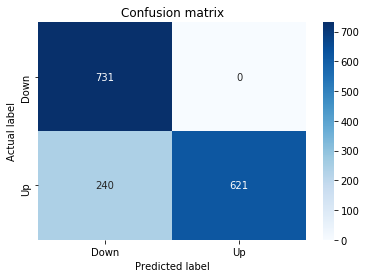

In [128]:
import sklearn.metrics as metrics
fig, ax=plt.subplots()
sns.heatmap(pd.DataFrame(metrics.confusion_matrix(Y_test, rounded)), annot=True, cmap="Blues" ,fmt='g')
plt.title('Confusion matrix'); plt.ylabel('Actual label'); plt.xlabel('Predicted label')
ax.xaxis.set_ticklabels(['Down', 'Up']); ax.yaxis.set_ticklabels(['Down', 'Up'])

In [117]:
y_pred_2_b=model.predict(X_test)


In [133]:
Y_test.type

AttributeError: 'numpy.ndarray' object has no attribute 'type'

In [131]:
import sys
import numpy
numpy.set_printoptions(threshold=sys.maxsize)
rounded = np.round(y_pred_2_b)

[[0.55492026]
 [0.5530878 ]
 [0.56059724]
 ...
 [0.8345509 ]
 [0.8345802 ]
 [0.8343097 ]]


In [134]:
display(Y_test
       )

array([0., 0., 1., 1., 0., 0., 1., 0., 0., 1., 0., 1., 1., 1., 1., 0., 0.,
       0., 1., 1., 0., 0., 1., 1., 0., 0., 1., 1., 1., 1., 1., 0., 1., 1.,
       0., 1., 0., 0., 1., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0.,
       1., 0., 1., 0., 1., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 1., 1.,
       1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1.,
       1., 1., 1., 0., 1., 1., 1., 1., 0., 0., 0., 0., 0., 1., 1., 1., 1.,
       0., 0., 1., 0., 0., 1., 0., 1., 1., 1., 1., 1., 0., 0., 1., 0., 1.,
       1., 0., 0., 0., 1., 0., 1., 1., 1., 0., 0., 1., 0., 1., 0., 1., 0.,
       1., 1., 1., 1., 1., 0., 0., 1., 1., 0., 1., 1., 0., 0., 1., 0., 0.,
       0., 0., 0., 1., 0., 1., 1., 1., 0., 1., 0., 0., 1., 0., 0., 0., 1.,
       0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 1., 0., 1., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 1., 1., 1., 0., 1., 0., 0., 1., 0., 1., 0., 1.,
       0., 1., 1., 0., 0., 1., 1., 0., 1., 1., 0., 0., 1., 1., 1., 0., 0.,
       1., 0., 1., 1., 1.

In [125]:
rounded.shape


(1592, 1)

In [126]:
rounded = rounded.reshape(-1)

In [64]:
display(rounded)

array([1., 1., 1., ..., 1., 1., 1.], dtype=float32)

In [65]:
display(Y_test)

array([  0.        ,   1.        ,   1.        , ...,   1.        ,
         1.        , 145.83340626])

In [91]:
 rounded = rounded[:-1]

In [92]:
Y_test = Y_test[:-1]